# Прогнозирование ряда со сложной сезонностью

In [101]:
import os
import pandas as pd
from datetime import datetime
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pylab as plt
from itertools import product 
import matplotlib.pylab as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\ptupi\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plot', 'product', 'plt', 'datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [14]:
os.chdir(r'E:\data science\6_module\1_week\3_projest\DATA')

#### В качестве региона, возьмем самый загруженнный регион - 1282

## 1.Выберите одну из зон среди отобранных на прошлой неделе, возьмите по ней все подготовленные данные о количестве поездок. Не используйте данные за последний имеющийся месяц — июнь 2016! Создайте регрессионные признаки для учёта сезонностей и трендов.

In [15]:
k = {'time': [], 'count': []}
df = pd.DataFrame(data=k)

In [10]:
regions = pd.read_csv('regions.csv', sep =';')

In [16]:
days = [31,29,31,30,31]
data_list = ['yellow_tripdata_2016-01.csv',
             'yellow_tripdata_2016-02.csv', 
             'yellow_tripdata_2016-03.csv', 
             'yellow_tripdata_2016-04.csv', 
             'yellow_tripdata_2016-05.csv']
for mounth, data in enumerate(data_list):
    data = pd.read_csv(data)
    #Фильтрация
    data = data[data.tpep_pickup_datetime != data.tpep_dropoff_datetime]
    data = data[data.passenger_count != 0]
    data = data[data.trip_distance != 0]
    data_filter = data[(data.pickup_longitude >= -74.25559) & 
                (data.pickup_longitude <= -73.70001) &
                (data.pickup_latitude >= 40.49612) &
                (data.pickup_latitude <= 40.91553)]
    data_filter['tpep_pickup_datetime'] = data_filter['tpep_pickup_datetime'].apply(lambda t: datetime.strptime(t, '%Y-%m-%d %H:%M:%S'))
    data_filter['pickup_hour'] = data_filter['tpep_pickup_datetime'].apply(lambda t: t.replace(minute=0, second=0))
    #Посик региона
    binx = np.append(regions.west.unique(),regions.east.max())
    biny = np.append(regions.south.unique(),regions.north.max())
    np.append(regions.west.unique(),regions.east.max())
    biny = np.append(regions.south.unique(),regions.north.max())
    regions['for_check_lon'] = (regions['west'] + regions['east'])/2
    regions['for_check_lat'] = (regions['north'] + regions['south'])/2

    r = stats.binned_statistic_2d(regions.for_check_lon.values,\
                                  regions.for_check_lat.values,\
                                  None, statistic='count', bins=[binx,biny],\
                                  expand_binnumbers = True)
    regions['check_region0'] = r.binnumber[0]
    regions['check_region1'] = r.binnumber[1]
    r = stats.binned_statistic_2d(data_filter.pickup_longitude.values,\
                                  data_filter.pickup_latitude.values,\
                                  None, statistic='count', bins=[binx,biny],\
                                  expand_binnumbers = True)
    data_filter['region'] = [50*(a-1)+b for a,b in zip(r.binnumber[0],r.binnumber[1])]
    d = data_filter[data_filter.region == 1282]
    for day in range(1,days[mounth]+1):
        for hour in range(24):
            new_line = {'time':datetime(2016,mounth+1,day,hour,0,0), 'count': len(d[d.pickup_hour == datetime(2016,mounth+1,day,hour,0,0)])}
            df = df.append(new_line, ignore_index=True)
    #Освобождаем память
    print(str(mounth+1)+' loaded' )
    del(data)
    del(data_filter)

C:\Users\ptupi\Anaconda2\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ptupi\Anaconda2\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\ptupi\Anaconda2\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexi

1 loaded
2 loaded
3 loaded
4 loaded
5 loaded


In [18]:
df.head()

,count,time
0,1076.0,2016-01-01 00:00:00
1,1178.0,2016-01-01 01:00:00
2,1053.0,2016-01-01 02:00:00
3,610.0,2016-01-01 03:00:00
4,401.0,2016-01-01 04:00:00


In [37]:
len(df)

3648

Text(0.5,0,u'date')

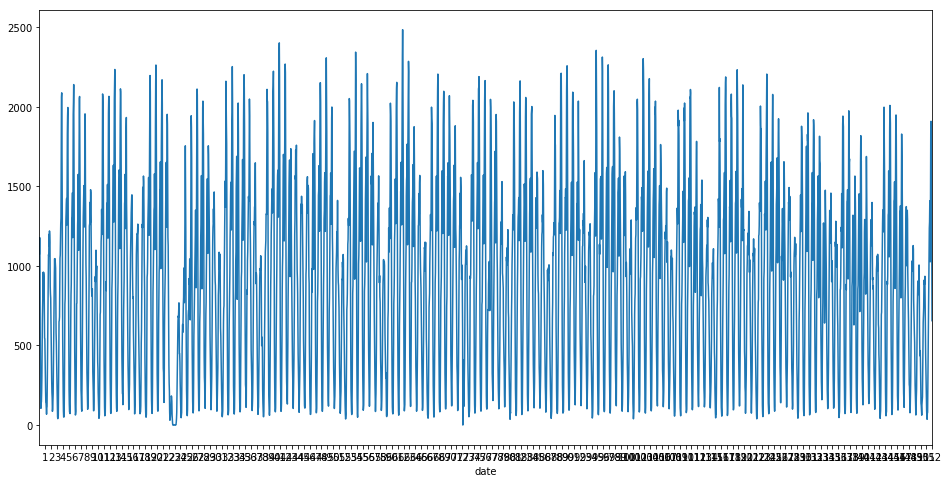

In [38]:
% matplotlib inline
plt.figure(figsize=(16,8))
x = df['count']
plt.plot(x)

dates = range(1,sum(days)+1)
plt.xticks([d*24 for d in dates],dates)
plt.xlim([0,3648])
plt.xlabel('date')

### На графике явно видна недельная и суточная сезонность, так же видно паения поездк конце января, добавим синусно-косинусные коэфициент

In [40]:
for i in xrange(2, 1001): 
    df['sin_{}'.format(i)] = np.sin(df['count'] * 2 * np.pi * i /168)
    df['cos_{}'.format(i)] = np.cos(df['count'] * 2 * np.pi * i /168)

In [41]:
df.head()

,count,time,sin_2,cos_2,sin_3,cos_3,sin_4,cos_4,sin_5,cos_5,...,sin_996,cos_996,sin_997,cos_997,sin_998,cos_998,sin_999,cos_999,sin_1000,cos_1000
0,1076.0,2016-01-01 00:00:00,-0.930874,0.365341,0.974928,0.222521,-0.680173,-0.733052,0.149042,0.988831,...,0.781831,0.623490,-0.294755,-0.955573,-0.294755,0.955573,0.781831,-0.623490,-0.997204,0.074730
1,1178.0,2016-01-01 01:00:00,0.149042,0.988831,0.222521,0.974928,0.294755,0.955573,0.365341,0.930874,...,-0.781831,0.623490,-0.733052,0.680173,-0.680173,0.733052,-0.623490,0.781831,-0.563320,0.826239
2,1053.0,2016-01-01 02:00:00,-0.222521,-0.974928,-0.943883,0.330279,0.433884,0.900969,0.846724,-0.532032,...,-0.974928,0.222521,0.330279,0.943883,0.900969,-0.433884,-0.532032,-0.846724,-0.781831,0.623490
3,610.0,2016-01-01 03:00:00,0.997204,-0.074730,-0.623490,0.781831,-0.149042,-0.988831,0.826239,0.563320,...,0.433884,-0.900969,0.365341,0.930874,-0.930874,-0.365341,0.900969,-0.433884,-0.294755,0.955573
4,401.0,2016-01-01 04:00:00,-0.988831,0.149042,0.846724,0.532032,-0.294755,-0.955573,-0.399892,0.916562,...,0.781831,-0.623490,-0.999301,-0.037391,0.733052,0.680173,-0.111964,-0.993712,-0.563320,0.826239


In [42]:
df['week_day'] =  map(lambda x: x.dayofweek, df.time)
df['hour'] = map(lambda x: x.hour, df.time)
week_day_dumies = pd.get_dummies(df['week_day'], prefix='week_day')
hour_dumies = pd.get_dummies(df['hour'], prefix='hour')

df = pd.concat([df, week_day_dumies, hour_dumies],axis=1)
df.drop(['week_day', 'hour'], axis=1, inplace=True)

In [44]:
df.columns

Index([u'count', u'time', u'sin_2', u'cos_2', u'sin_3', u'cos_3', u'sin_4',
       u'cos_4', u'sin_5', u'cos_5',
       ...
       u'hour_14', u'hour_15', u'hour_16', u'hour_17', u'hour_18', u'hour_19',
       u'hour_20', u'hour_21', u'hour_22', u'hour_23'],
      dtype='object', length=2031)

## 2. Чтобы примерно подобрать порядки дифференцирования ряда в модели ARIMA, сделайте регрессию целевого признака — количества поездок — на построенные признаки. Посмотрите на остатки регрессии. Если регрессионные признаки подобраны идеально, то в них должна остаться только внутрисуточная сезонность. Вслепую идеально подобрать признаки вам вряд ли удастся, так что в остатках вы, скорее всего, увидите много интересного, в том числе праздники, аномалии, тренды и многое другое.

In [108]:
df.index = pd.DatetimeIndex(df.time)

In [109]:
def coppy(pattern, min, max):
    return [pattern % str(i) for i in range(min, max + 1)]

In [164]:
def plot(k):
    variables =  coppy('hour_%s', 0, 23) \
    + coppy('week_day_%s', 0, 6) + \
    coppy('sin_%s', 2, k) + \
    coppy('cos_%s', 2, k)
    X_train = df[variables]
    y_train = df['count']

    lr=sm.OLS(y_train, X_train)
    model=lr.fit()

    df['prediction']=model.predict(df[variables])
    q=df.groupby(pd.TimeGrouper(freq='D'))['count'].sum()
    pr=df.groupby(pd.TimeGrouper(freq='D')).prediction.sum()
    fig = plt.figure(figsize=(25,5))
    pr.plot()
    q.plot()
    
    return df['count']-df['prediction']

In [111]:
def plot_diffs(diffs):
    sm.tsa.seasonal_decompose(diffs, freq=24).plot()
    print("Кр-рий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(diffs)[1])

## Возьмем  К = 100

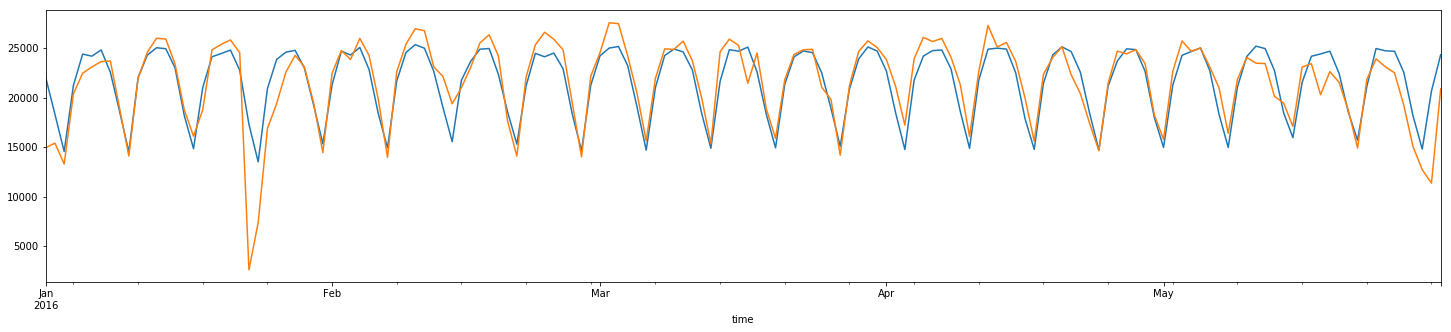

In [112]:
diffs100 = plot(100)

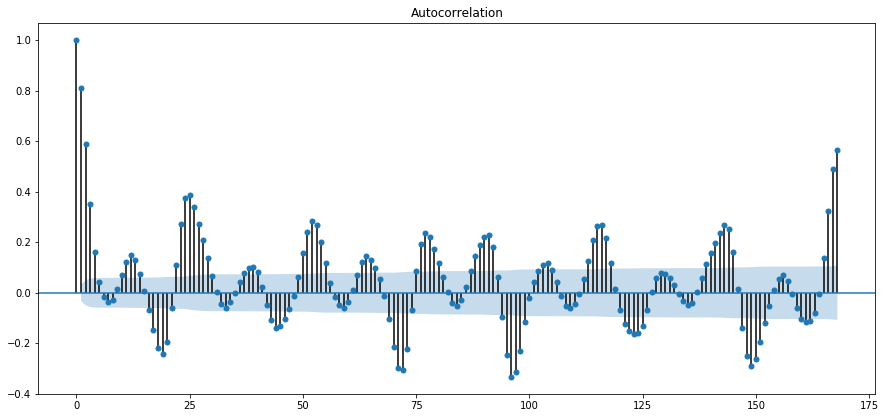

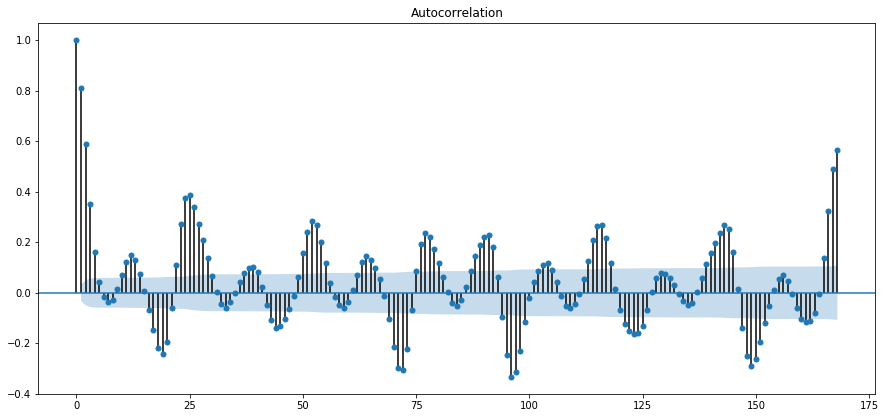

In [113]:
sm.graphics.tsa.plot_acf(diffs100.squeeze(), lags=168, ax=plt.subplot(211))

Кр-рий Дики-Фуллера: p=0.000000


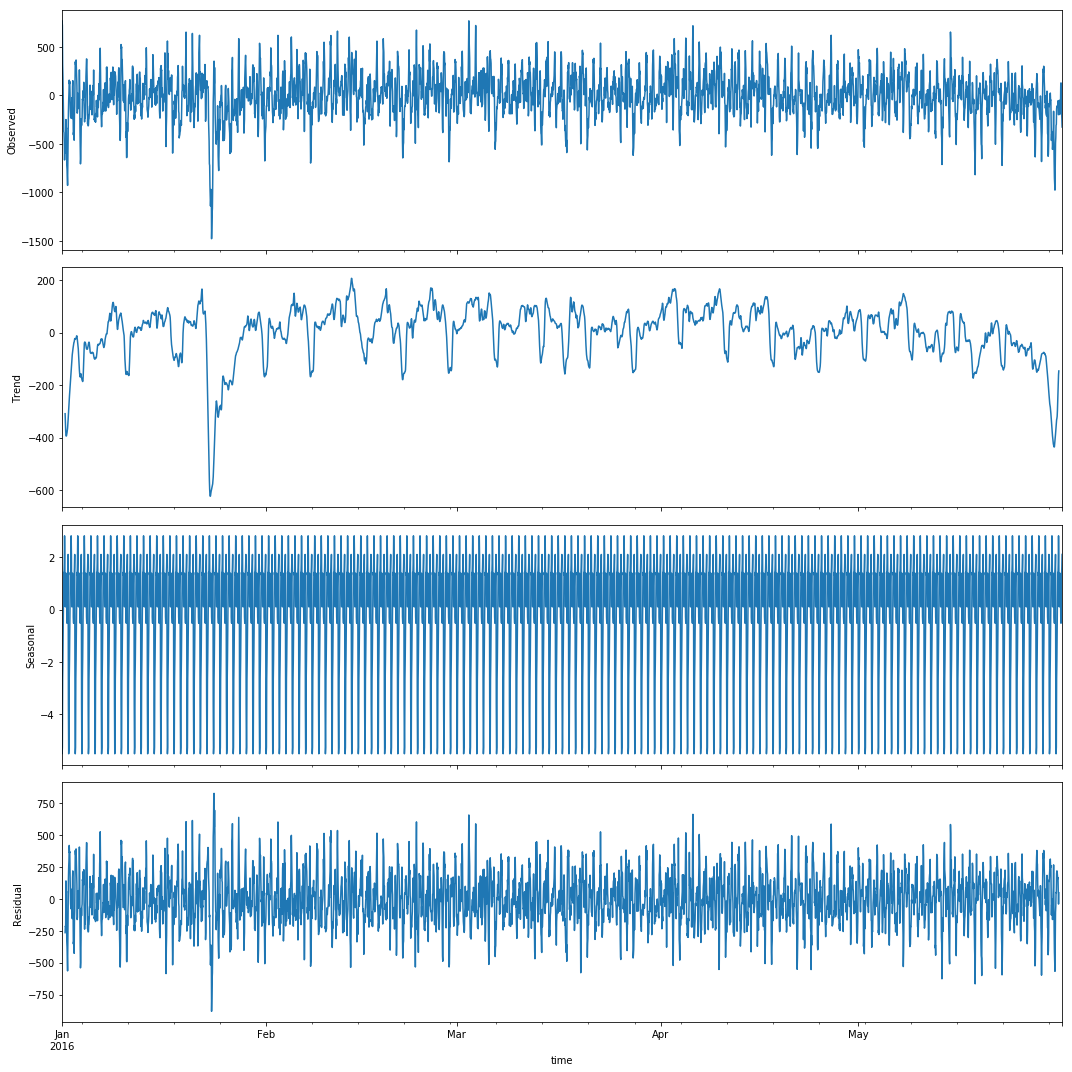

In [114]:
plt.figure(figsize=(20,10))
plot_diffs(diffs100)

## Увеличим K 1000

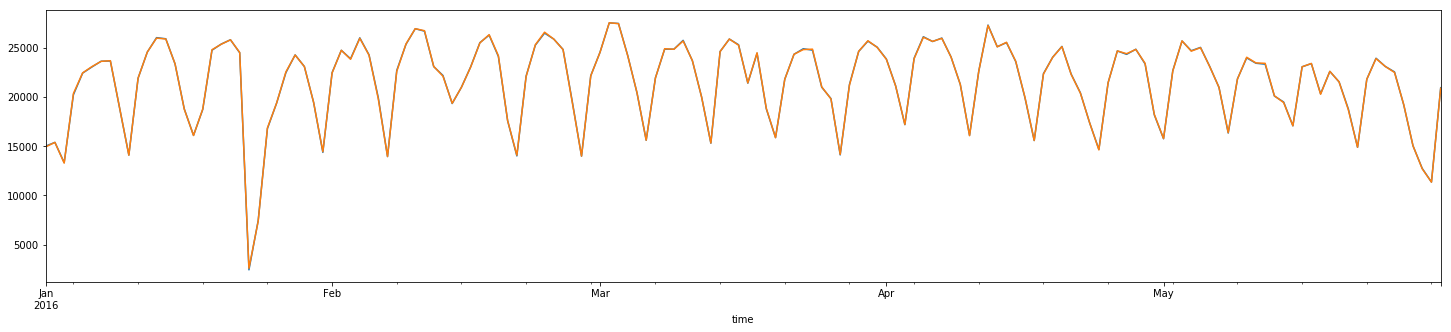

In [115]:
diffs1000  = plot(1000)

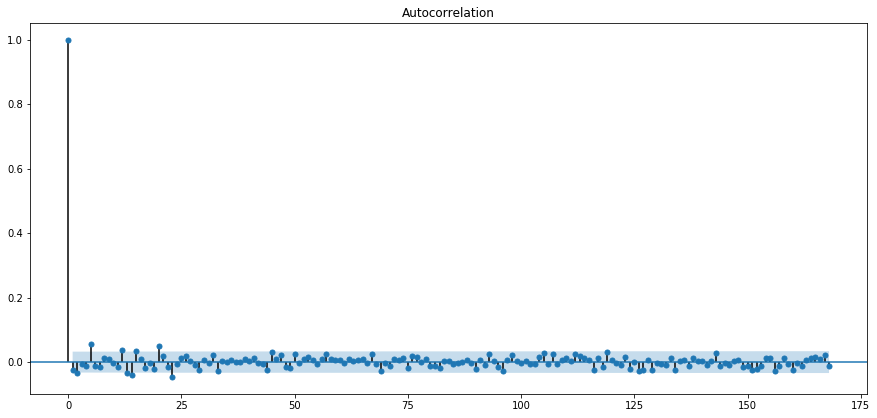

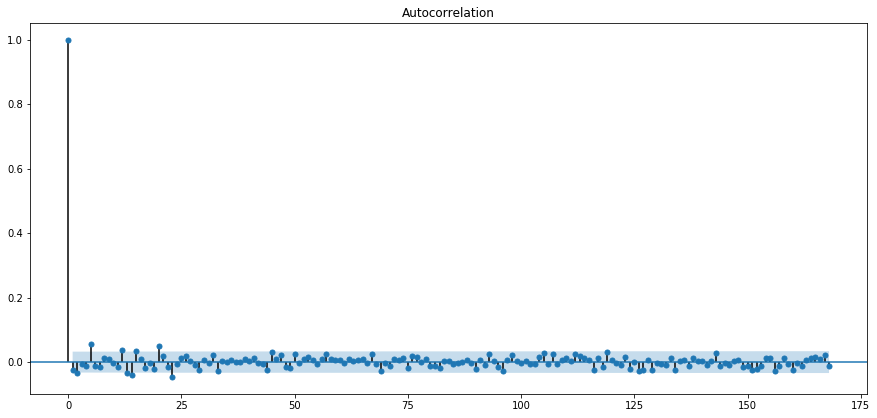

In [116]:
sm.graphics.tsa.plot_acf(diffs1000.squeeze(), lags=168, ax=plt.subplot(211))

Кр-рий Дики-Фуллера: p=0.000000


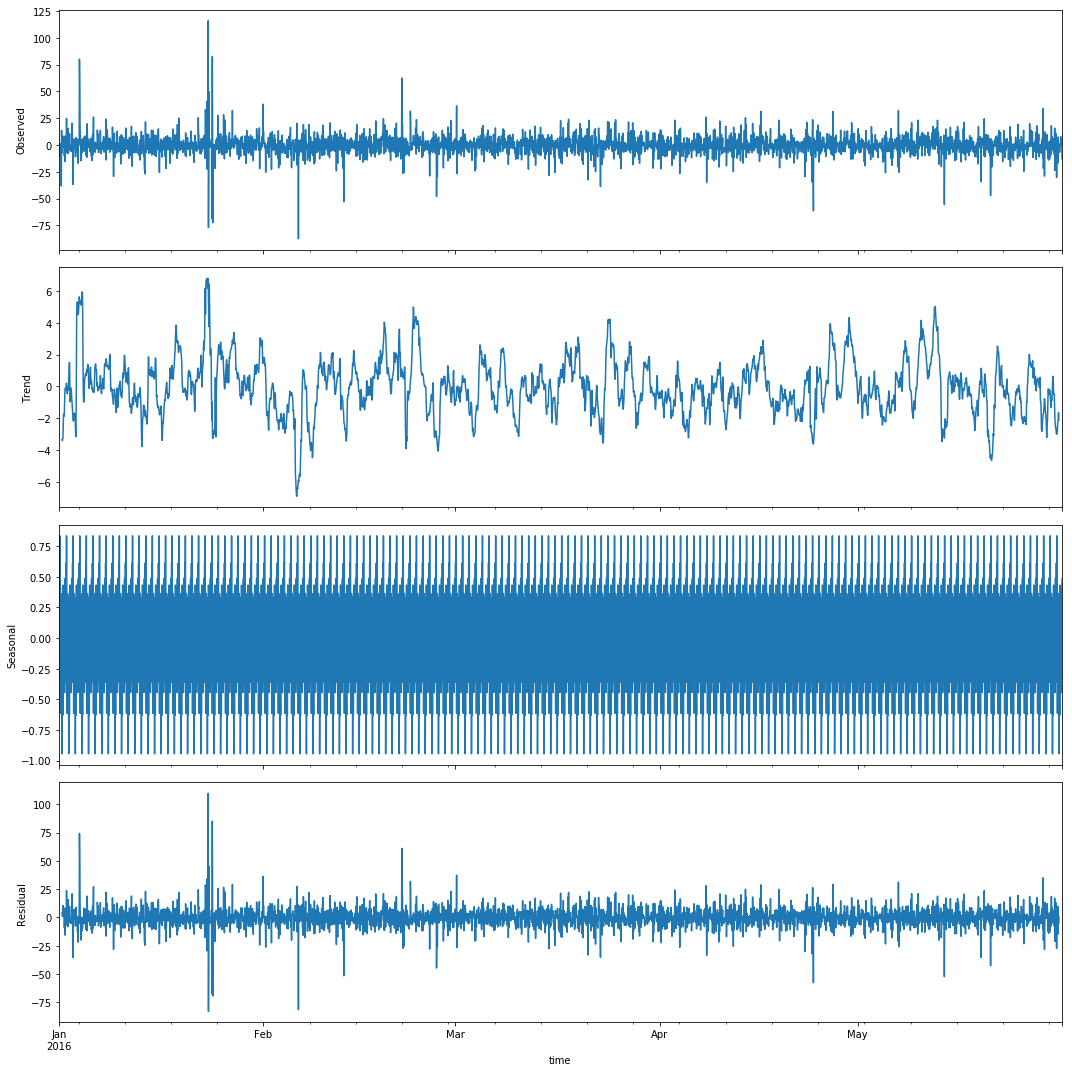

In [117]:
plt.figure(figsize=(20,10))
plot_diffs(diffs1000)

# Модель явно переобучена!!!
##  Возьмем K = 150

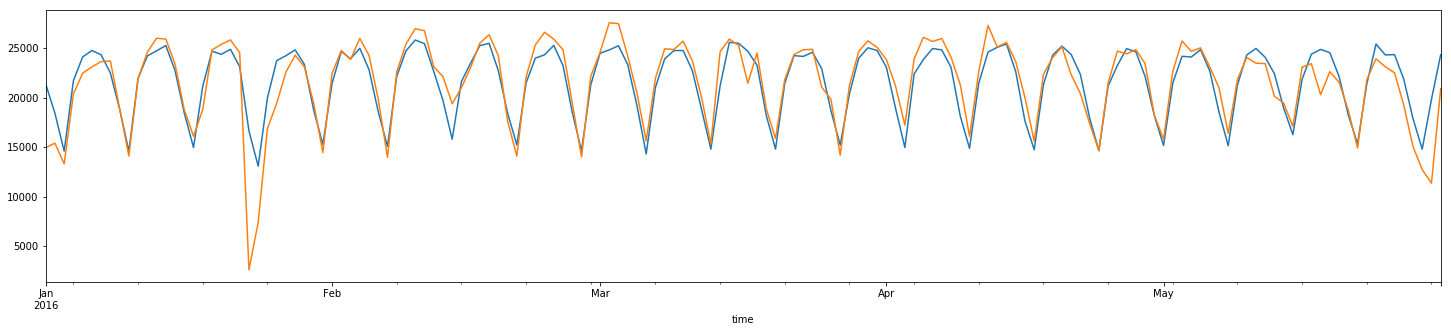

In [118]:
diffs150 = plot(150)

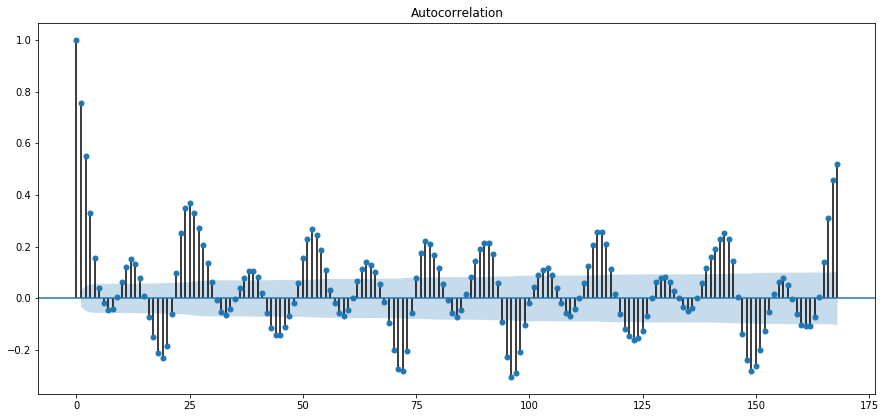

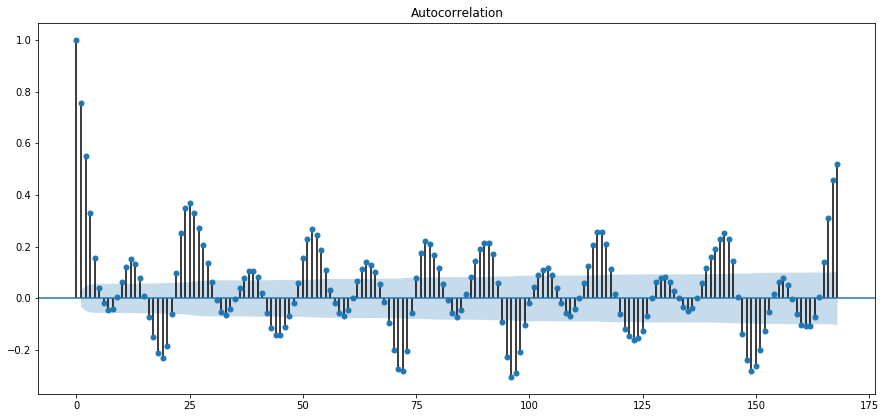

In [121]:
sm.graphics.tsa.plot_acf(diffs150.squeeze(), lags=168, ax=plt.subplot(211))

Кр-рий Дики-Фуллера: p=0.000000


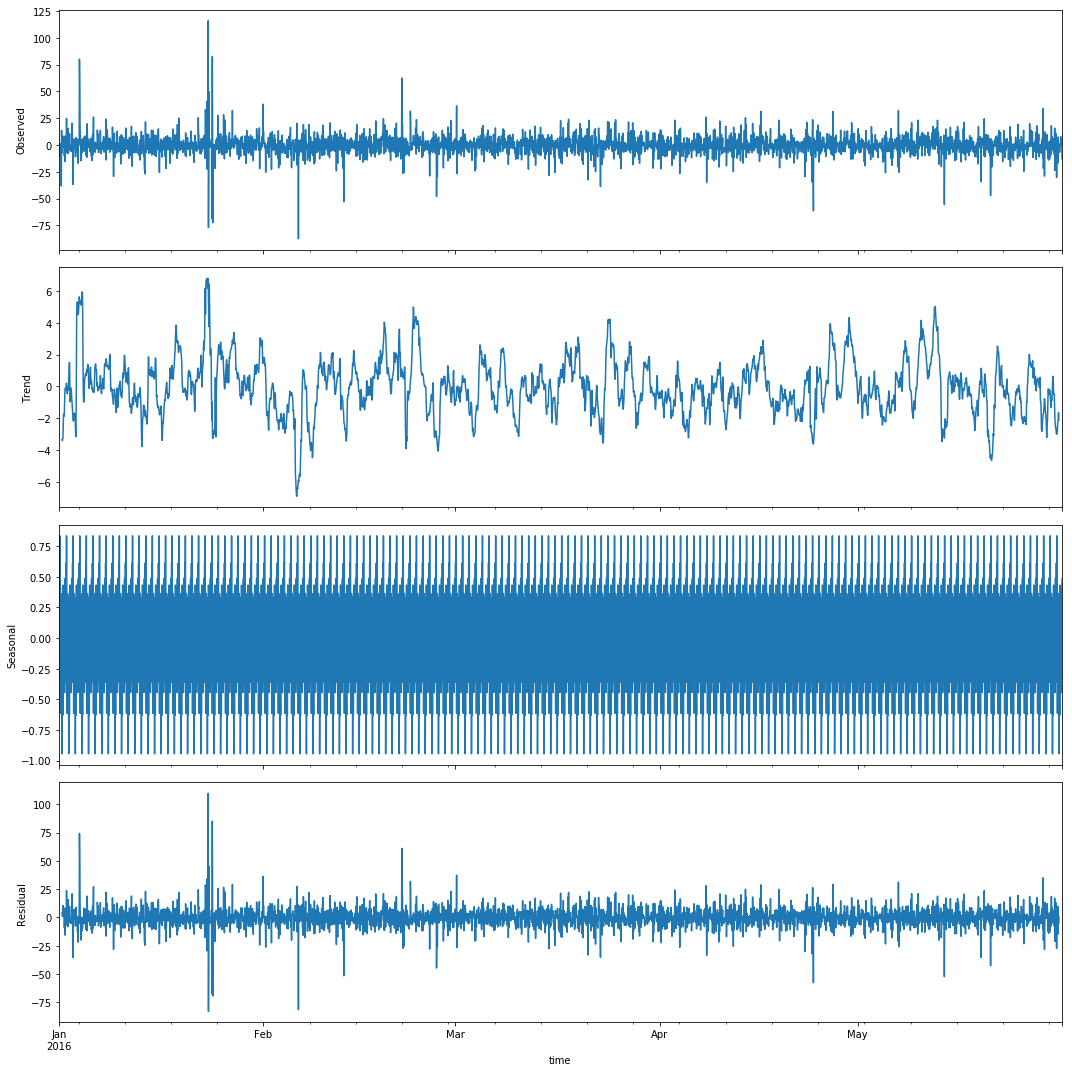

In [120]:
plt.figure(figsize=(20,10))
plot_diffs(diffs1000)

# 3.Чтобы подобрать значения гиперпараметров ARIMA, попробуйте сделать ряд остатков стационарным. Если необходимо, сделайте несколько дифференцирований. Из-за большого количества аномальных дней (праздники и т.д.) вряд ли вам удастся сделать так, что критерий Дики-Фуллера не будет отвергать гипотезу нестационарности, поэтому при выборе порядка дифференцирования ориентируйтесь в первую очередь на результат STL-декомпозиции

In [122]:
df['hour_diff'] = diffs150 - diffs150.shift(1)
df['hour_diff'] = df['hour_diff'] - df['hour_diff'].shift(1)
df['hour_diff'] = df['hour_diff'] - df['hour_diff'].shift(1)
df['hour_diff2'] = df['hour_diff'] - df['hour_diff'].shift(1)

Кр-рий Дики-Фуллера: p=0.000000


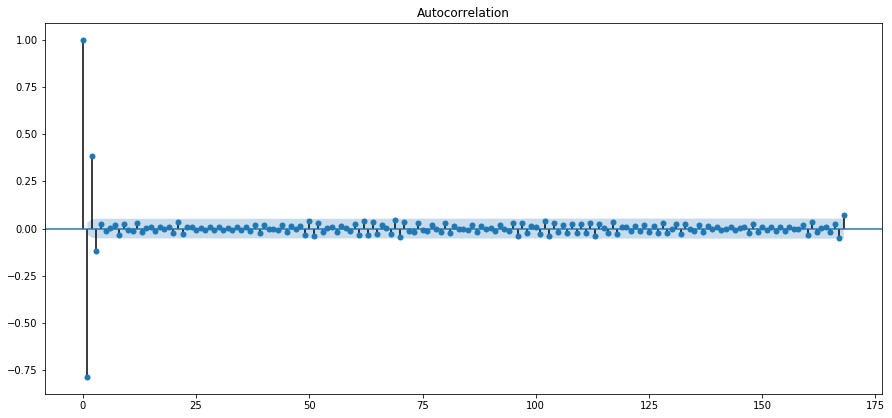

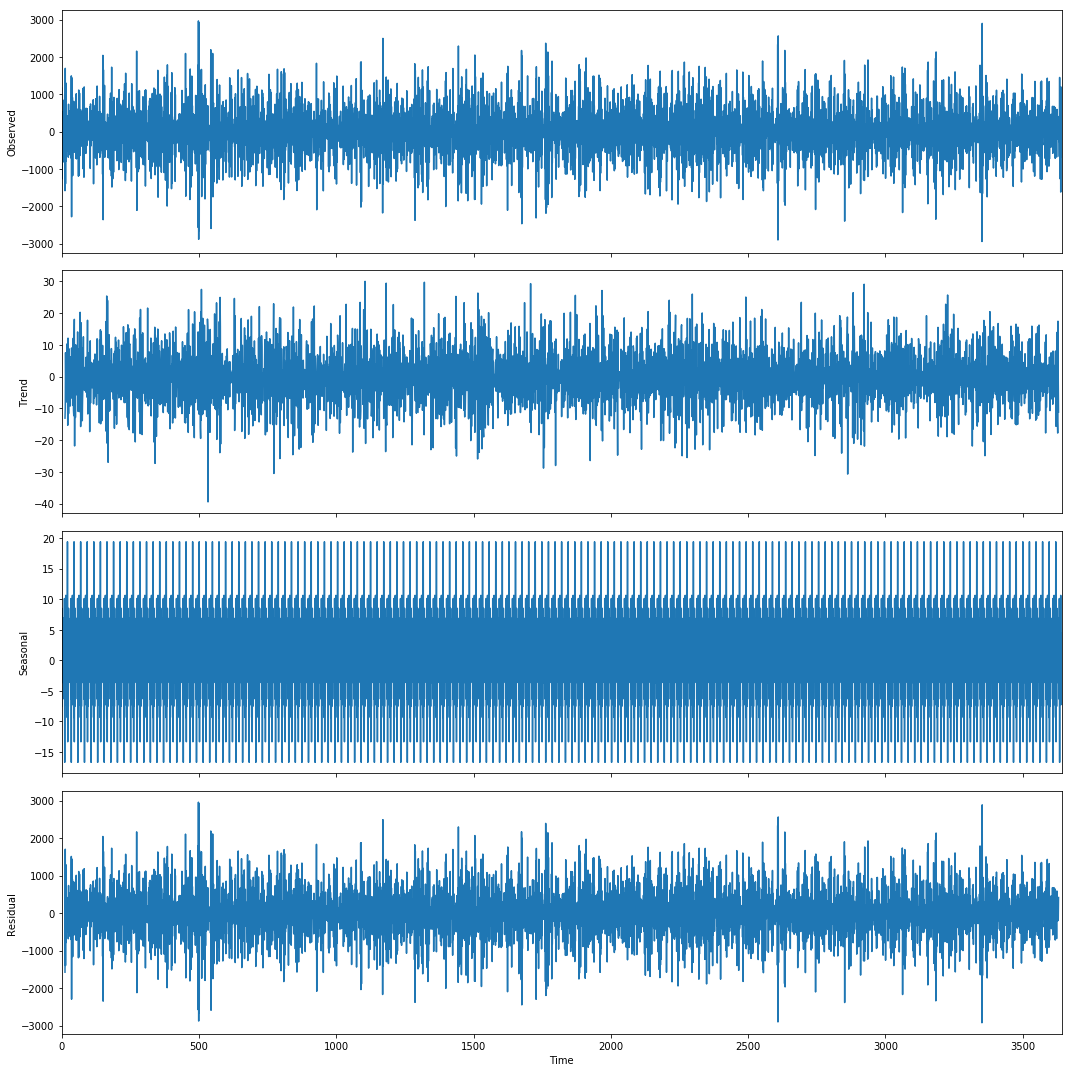

Кр-рий Дики-Фуллера: p=0.000000


In [123]:
plt.figure(figsize(15,15))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df['hour_diff2'].values[4:].squeeze(), lags=168, ax=ax)
plot_diffs(df['hour_diff2'].values[4:])
pylab.show()
print("Кр-рий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.hour_diff2[4:])[1])

# 4.Постройте ACF и PACF полученного ряда остатков (возможно, продифференцированных) с максимальным лагом не меньше длины самого длинного сезонного периода (неделя или год), подберите по ним начальные приближения для параметров p,q,P,Q. Используйте эти начальные приближения при переборе моделей ARIMA исходного ряда, не забывая подавать функции SARIMAX регрессионные признаки в качестве параметра exog.

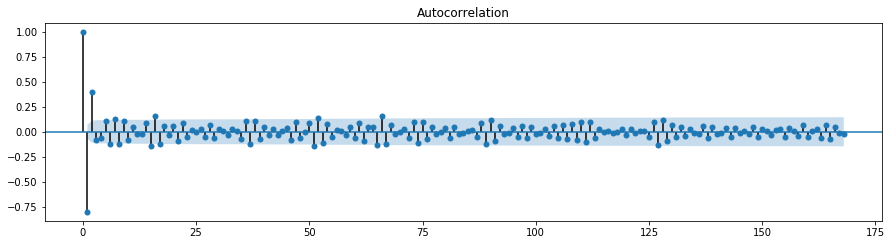

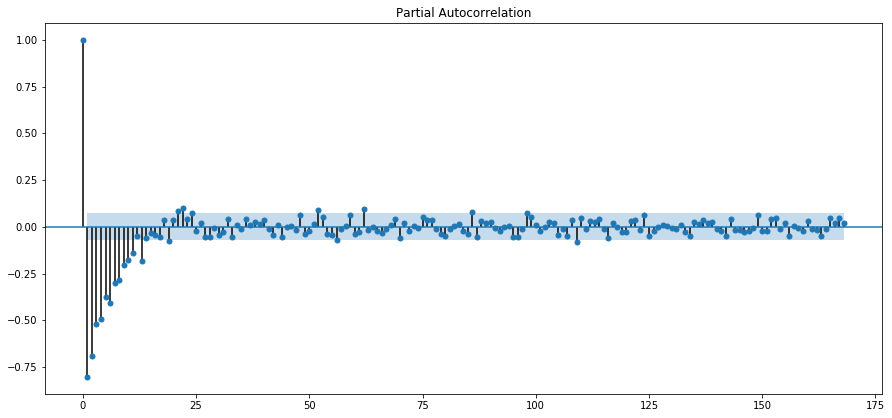

In [206]:
plt.figure(figsize=(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df['hour_diff2'].values[4:].squeeze(), lags=168, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df['hour_diff2'].values[4:].squeeze(), lags=168, ax=ax)
plt.show()

# Определим начальные приближения параметров SARIMA:
    Q = 0, P = 0, q = 3, p = 14

# 5. Выберите оптимальную по AIC модель; постройте график исходного ряда и нарисуйте поверх предсказания выбранной модели. Если модель плохо описывает данные, попробуйте увеличить количество синусов и косинусов K или поменять порядки дифференцирования

In [135]:
from itertools import product 
ps = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
d = 4
qs = [0,1,2,3]
P = 0
D = 0
Q = 0
parameters = product(ps, qs)
parameters_list = list(parameters)
len(parameters_list)
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

In [166]:
%time
for param in parameters_list:
    try:
        model=sm.tsa.statespace.SARIMAX(diffs150, order=(param[0], d, param[1]), seasonal_order=(P, D, Q, 24)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])    
warnings.filterwarnings('default')

Wall time: 0 ns
('wrong parameters:', (0, 0))
('wrong parameters:', (0, 1))
('wrong parameters:', (0, 2))
('wrong parameters:', (0, 3))
('wrong parameters:', (1, 1))
('wrong parameters:', (1, 2))
('wrong parameters:', (1, 3))
('wrong parameters:', (2, 2))
('wrong parameters:', (2, 3))
('wrong parameters:', (3, 2))
('wrong parameters:', (3, 3))
('wrong parameters:', (4, 1))
('wrong parameters:', (4, 3))
('wrong parameters:', (5, 1))
('wrong parameters:', (5, 2))
('wrong parameters:', (5, 3))
('wrong parameters:', (6, 1))
('wrong parameters:', (6, 2))
('wrong parameters:', (6, 3))
('wrong parameters:', (7, 1))
('wrong parameters:', (7, 2))
('wrong parameters:', (7, 3))
('wrong parameters:', (8, 1))
('wrong parameters:', (8, 2))
('wrong parameters:', (8, 3))
('wrong parameters:', (9, 1))
('wrong parameters:', (9, 2))
('wrong parameters:', (9, 3))
('wrong parameters:', (10, 1))
('wrong parameters:', (10, 2))
('wrong parameters:', (10, 3))
('wrong parameters:', (11, 1))
('wrong parameters:'

In [167]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

   parameters           aic
16    (14, 0)  49435.074911
15    (13, 0)  49571.404872
14    (12, 0)  49711.310396
13    (11, 0)  49855.228007
12    (10, 0)  49962.079811


In [168]:
print(best_model.summary())

                           Statespace Model Results                           
Dep. Variable:                      y   No. Observations:                 3648
Model:              SARIMAX(14, 4, 0)   Log Likelihood              -24702.537
Date:                Sat, 18 Nov 2017   AIC                          49435.075
Time:                        20:25:20   BIC                          49528.104
Sample:                    01-01-2016   HQIC                         49468.206
                         - 05-31-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.4377      0.016   -156.576      0.000      -2.468      -2.407
ar.L2         -3.7805      0.041    -91.304      0.000      -3.862      -3.699
ar.L3         -4.8250      0.072    -66.834      0.0

Критерий Дики-Фуллера: p=0.000000


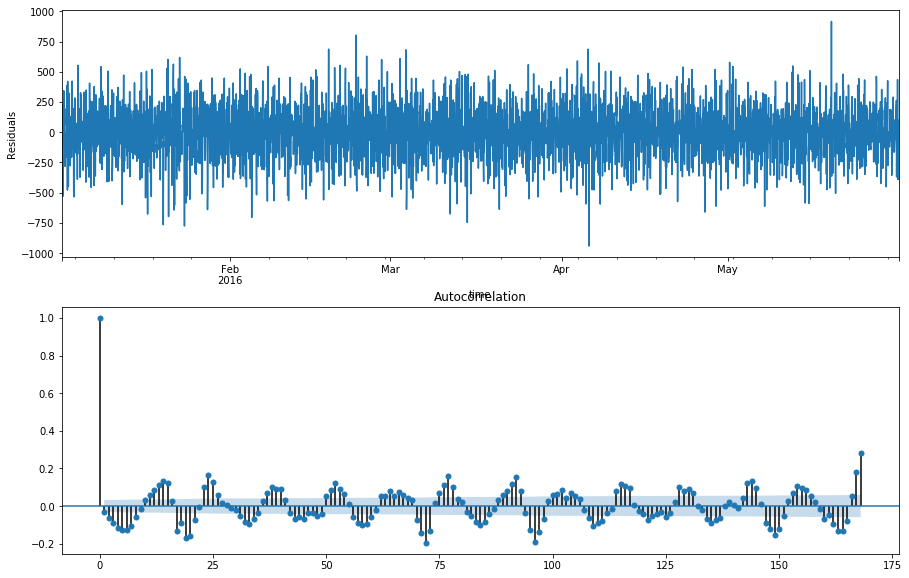

In [169]:
plt.figure(figsize=(15,10))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=168, ax=ax)

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

## 6. Проанализируйте качество построенной модели. Опишите, в какие периоды она плохо описывает данные? Можно ли заранее предсказать её поведение в такие периоды и улучшить тем самым прогноз? Если да, попробуйте создать для таких периодов регрессионные признаки и вернитесь к пункту 2.

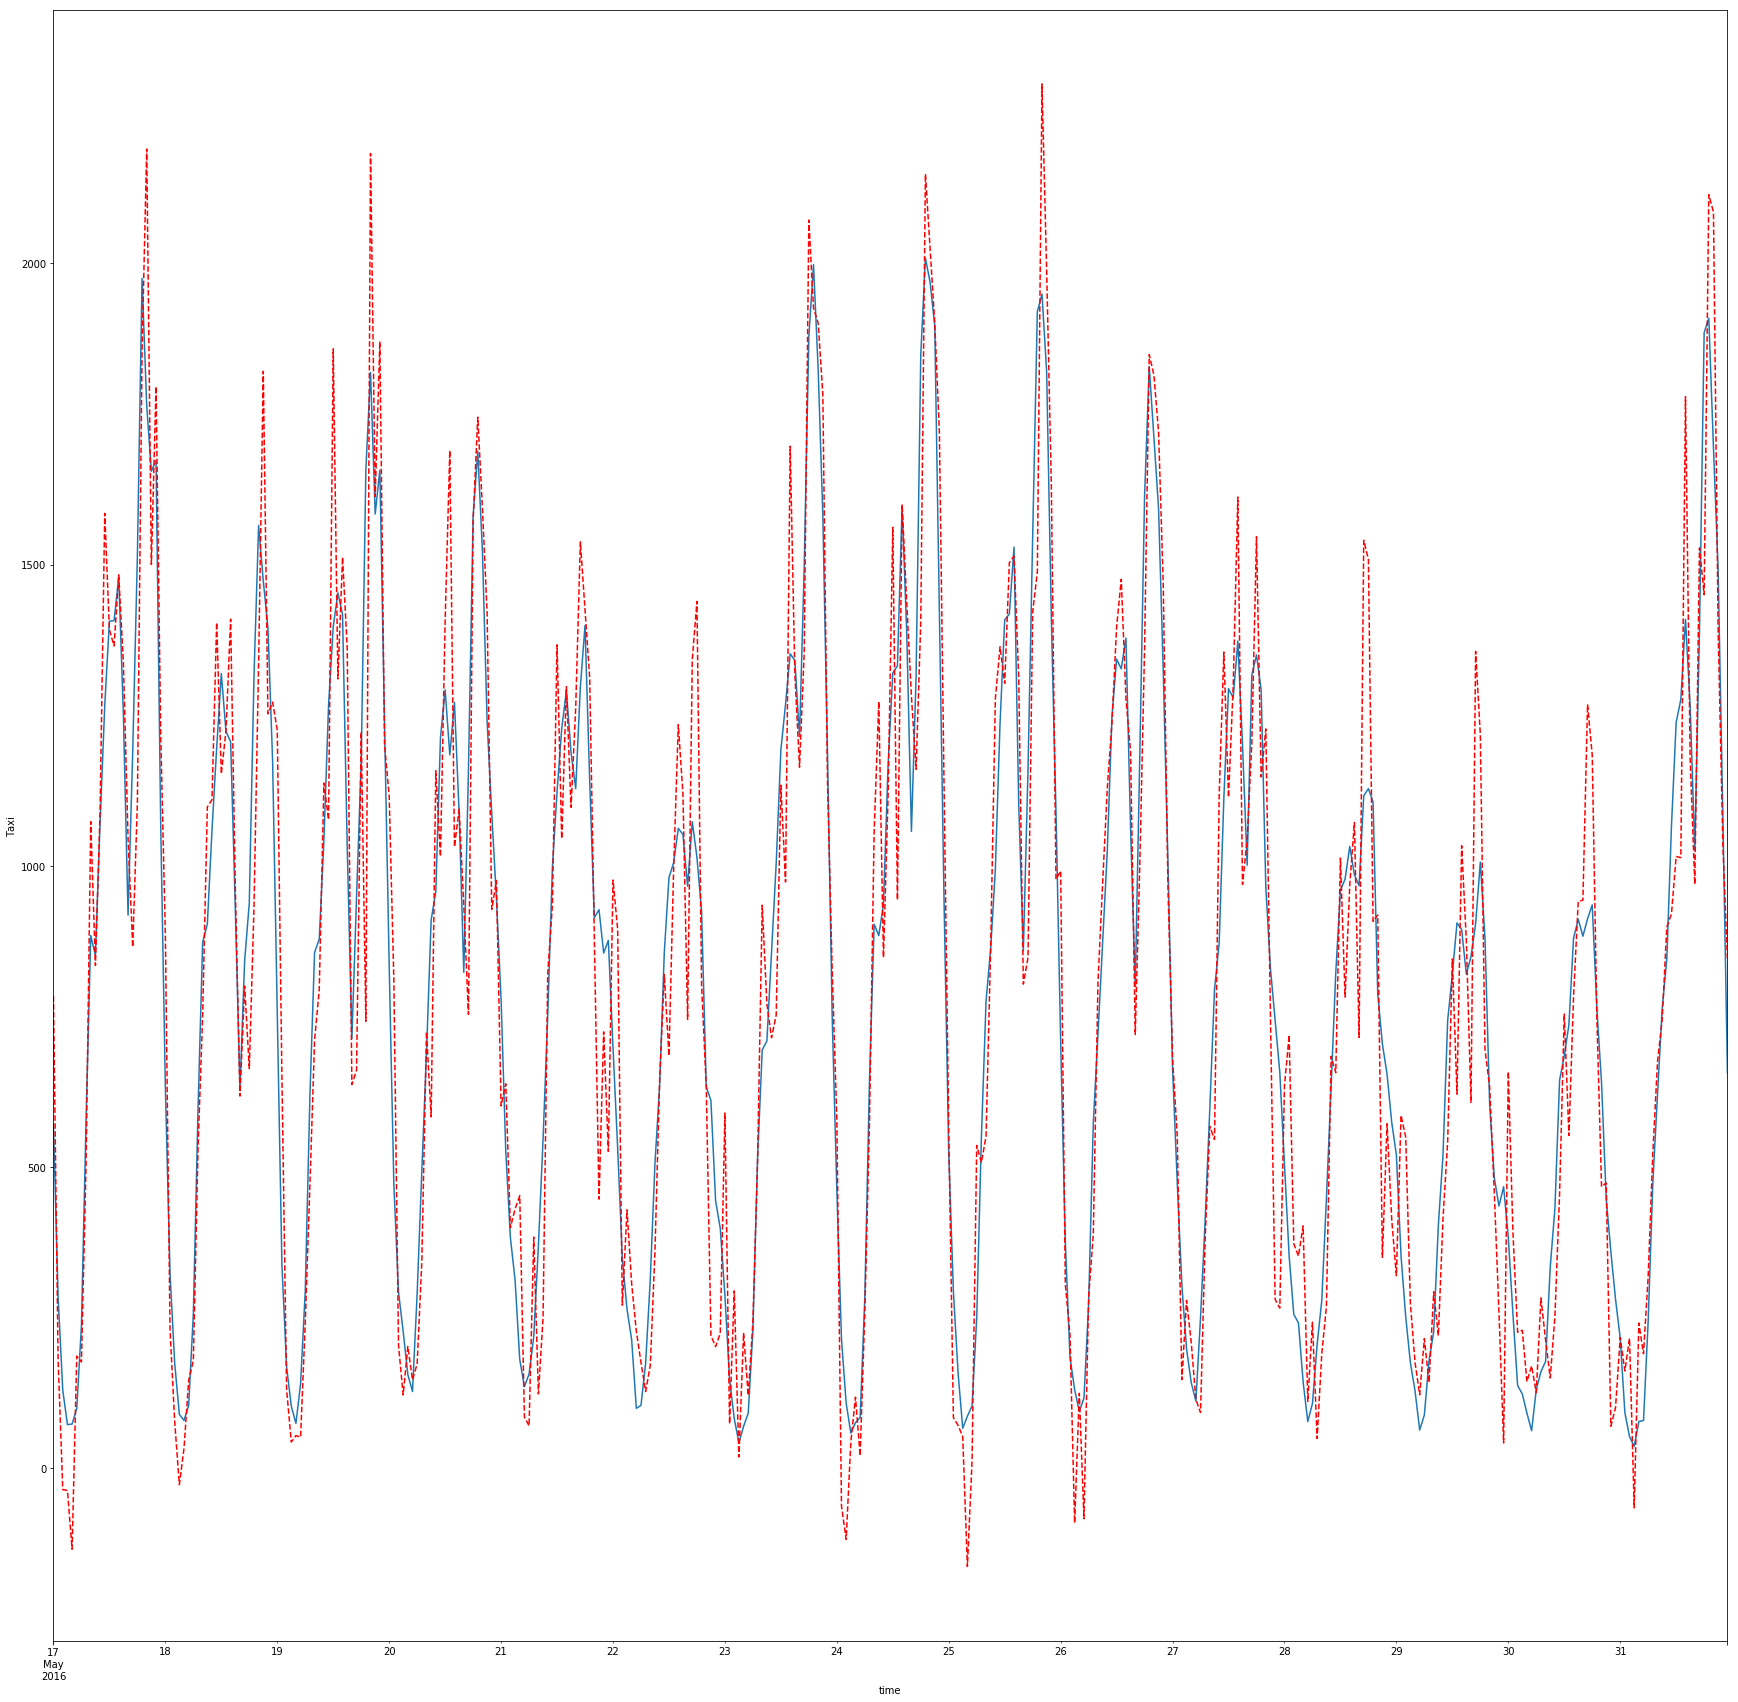

In [181]:
df['ARIMA']=best_model.fittedvalues
df['model'] = df.prediction+df['ARIMA']
plt.figure(figsize=(30,30))
df['count'][len(df)-15*24:len(df)].plot()
df.model[len(df)-15*24:len(df)].plot( style='r--')
plt.ylabel('Taxi')
plt.show()

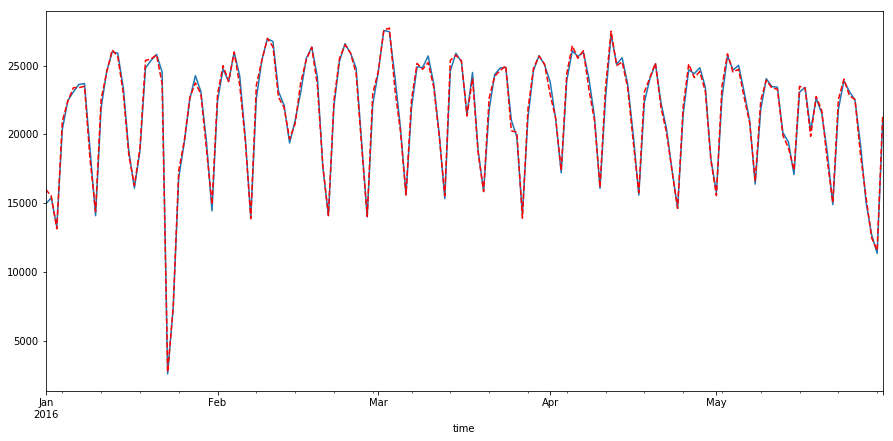

In [180]:
plt.figure(figsize=(15,7))
df.groupby(pd.TimeGrouper(freq='D'))['count'].sum().plot()
df.groupby(pd.TimeGrouper(freq='D')).model.sum().plot(style='r--')

#  Полученная ARIMA модель хорошо описывает параметры данной модели